In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
import scipy.cluster.hierarchy as sch
import numpy as np

In [2]:
country_data = pd.read_csv('./data/country-data.csv')
data_dictionary = pd.read_csv('./data/data-dictionary.csv')

In [3]:
num_countries = country_data.shape[0]
print(f"O número de países no dataset é: {num_countries}")
num_unique_countries = country_data['country'].nunique()
print(f"O número de países únicos no dataset é: {num_unique_countries}")

O número de países no dataset é: 167
O número de países únicos no dataset é: 167


In [4]:
country_data.set_index('country', inplace=True)
country_data.describe().T
num_cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

Já de início pode se perceber que os valores de income e gdpp possuem valores máximos MUITO acima dos outros valores

/var/folders/0d/h4ww2hdn1b912t6nchjlj9940000gn/T/ipykernel_8081/1864495679.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


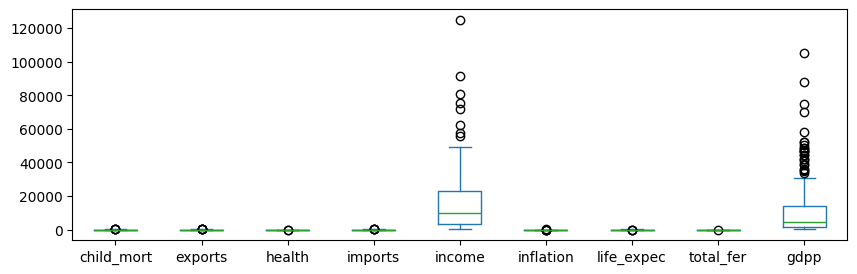

In [5]:
fig, ax = plt.subplots()
country_data.plot(kind='box', ax=ax, figsize=(10,3))
fig.show()

A partir do gráfico boxplot acima é muito mais fácil notar a grande diferença de escala das variáveis income e gdpp assim como alguns outliers. Sendo assim, necessário fazer uma normalização destes dados

In [6]:
# Centralizando todos os dados e colocando todo mundo com desvio padrão igualitário

scaler = StandardScaler()
country_data_scaled = scaler.fit_transform(country_data)
country_data_scaled = pd.DataFrame(country_data_scaled, columns=country_data.columns, index=country_data.index)

/var/folders/0d/h4ww2hdn1b912t6nchjlj9940000gn/T/ipykernel_8081/1597624000.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


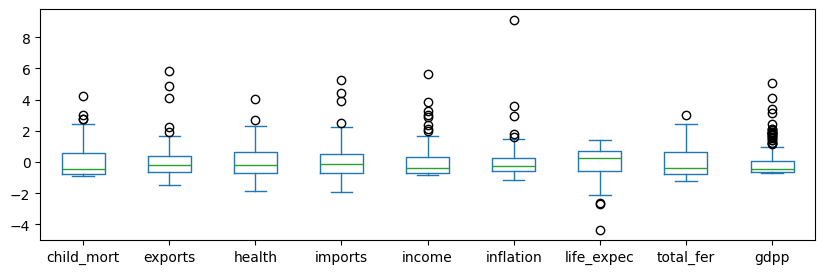

In [7]:
fig, ax = plt.subplots()
country_data_scaled.plot(kind='box', ax=ax, figsize=(10,3))
fig.show()

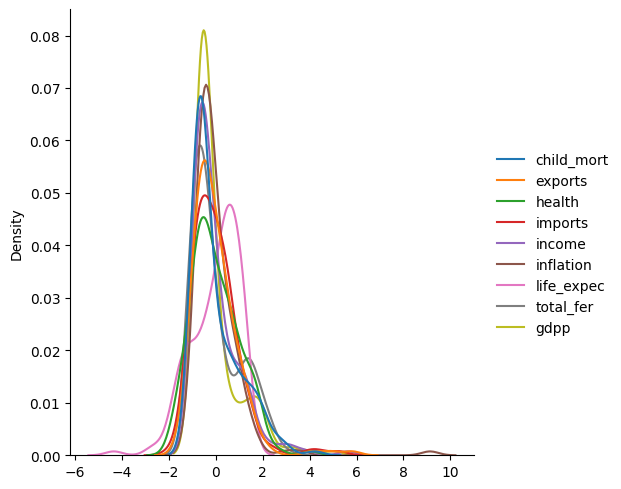

In [8]:
sns.displot(country_data_scaled, kind='kde')

<Axes: >

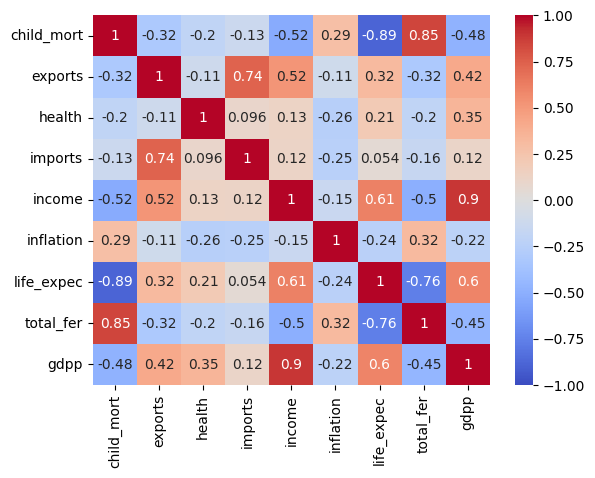

In [9]:
# Também é bom analizar o
sns.heatmap(country_data_scaled.corr(), cmap='coolwarm', annot=True, vmax=1, vmin=-1)

Algumas observações a respeito da matriz de correlação:

child_mor e total_fer são altamente correlacionadas, o que faz sentido, pois quanto maior a taxa de mortalidade infantil, maior a taxa de fertilidade.<br>
exports e imports são altamente correlacionadas.<br>
income e gdpp são altamente correlacionadas.<br>

In [10]:
min_clusters = 2
max_clusters = 10
n_init = 100

errors = []
for n_clusters in range(min_clusters, max_clusters):
  model = KMeans(
      n_clusters = n_clusters,
      init = "random",
      n_init = n_init,
      max_iter=1000,
  )

  model.fit(country_data_scaled)
  errors.append((n_clusters, model.inertia_))

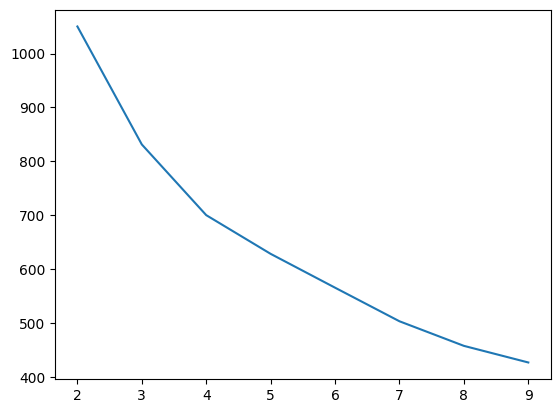

In [11]:
clusters, inertia = zip(*errors)
plt.plot(clusters, inertia)

A partir da análise de cotovelo é possível notar que perto de 3 clusters, o erro já diminui bastante. Sendo assim este seria um valor interessante para o número de grupos para resolver o problema

In [12]:
best_n_clusters = 3
n_init = 100
# n_init=100
model = KMeans(
    n_clusters = best_n_clusters,
    init="random",
    n_init=n_init,
    max_iter=1000,
)

model.fit(country_data_scaled)

results = country_data_scaled.copy()
results['cluster'] = model.predict(country_data_scaled)

In [13]:
results['cluster'].value_counts()

cluster
0    84
1    47
2    36
Name: count, dtype: int64

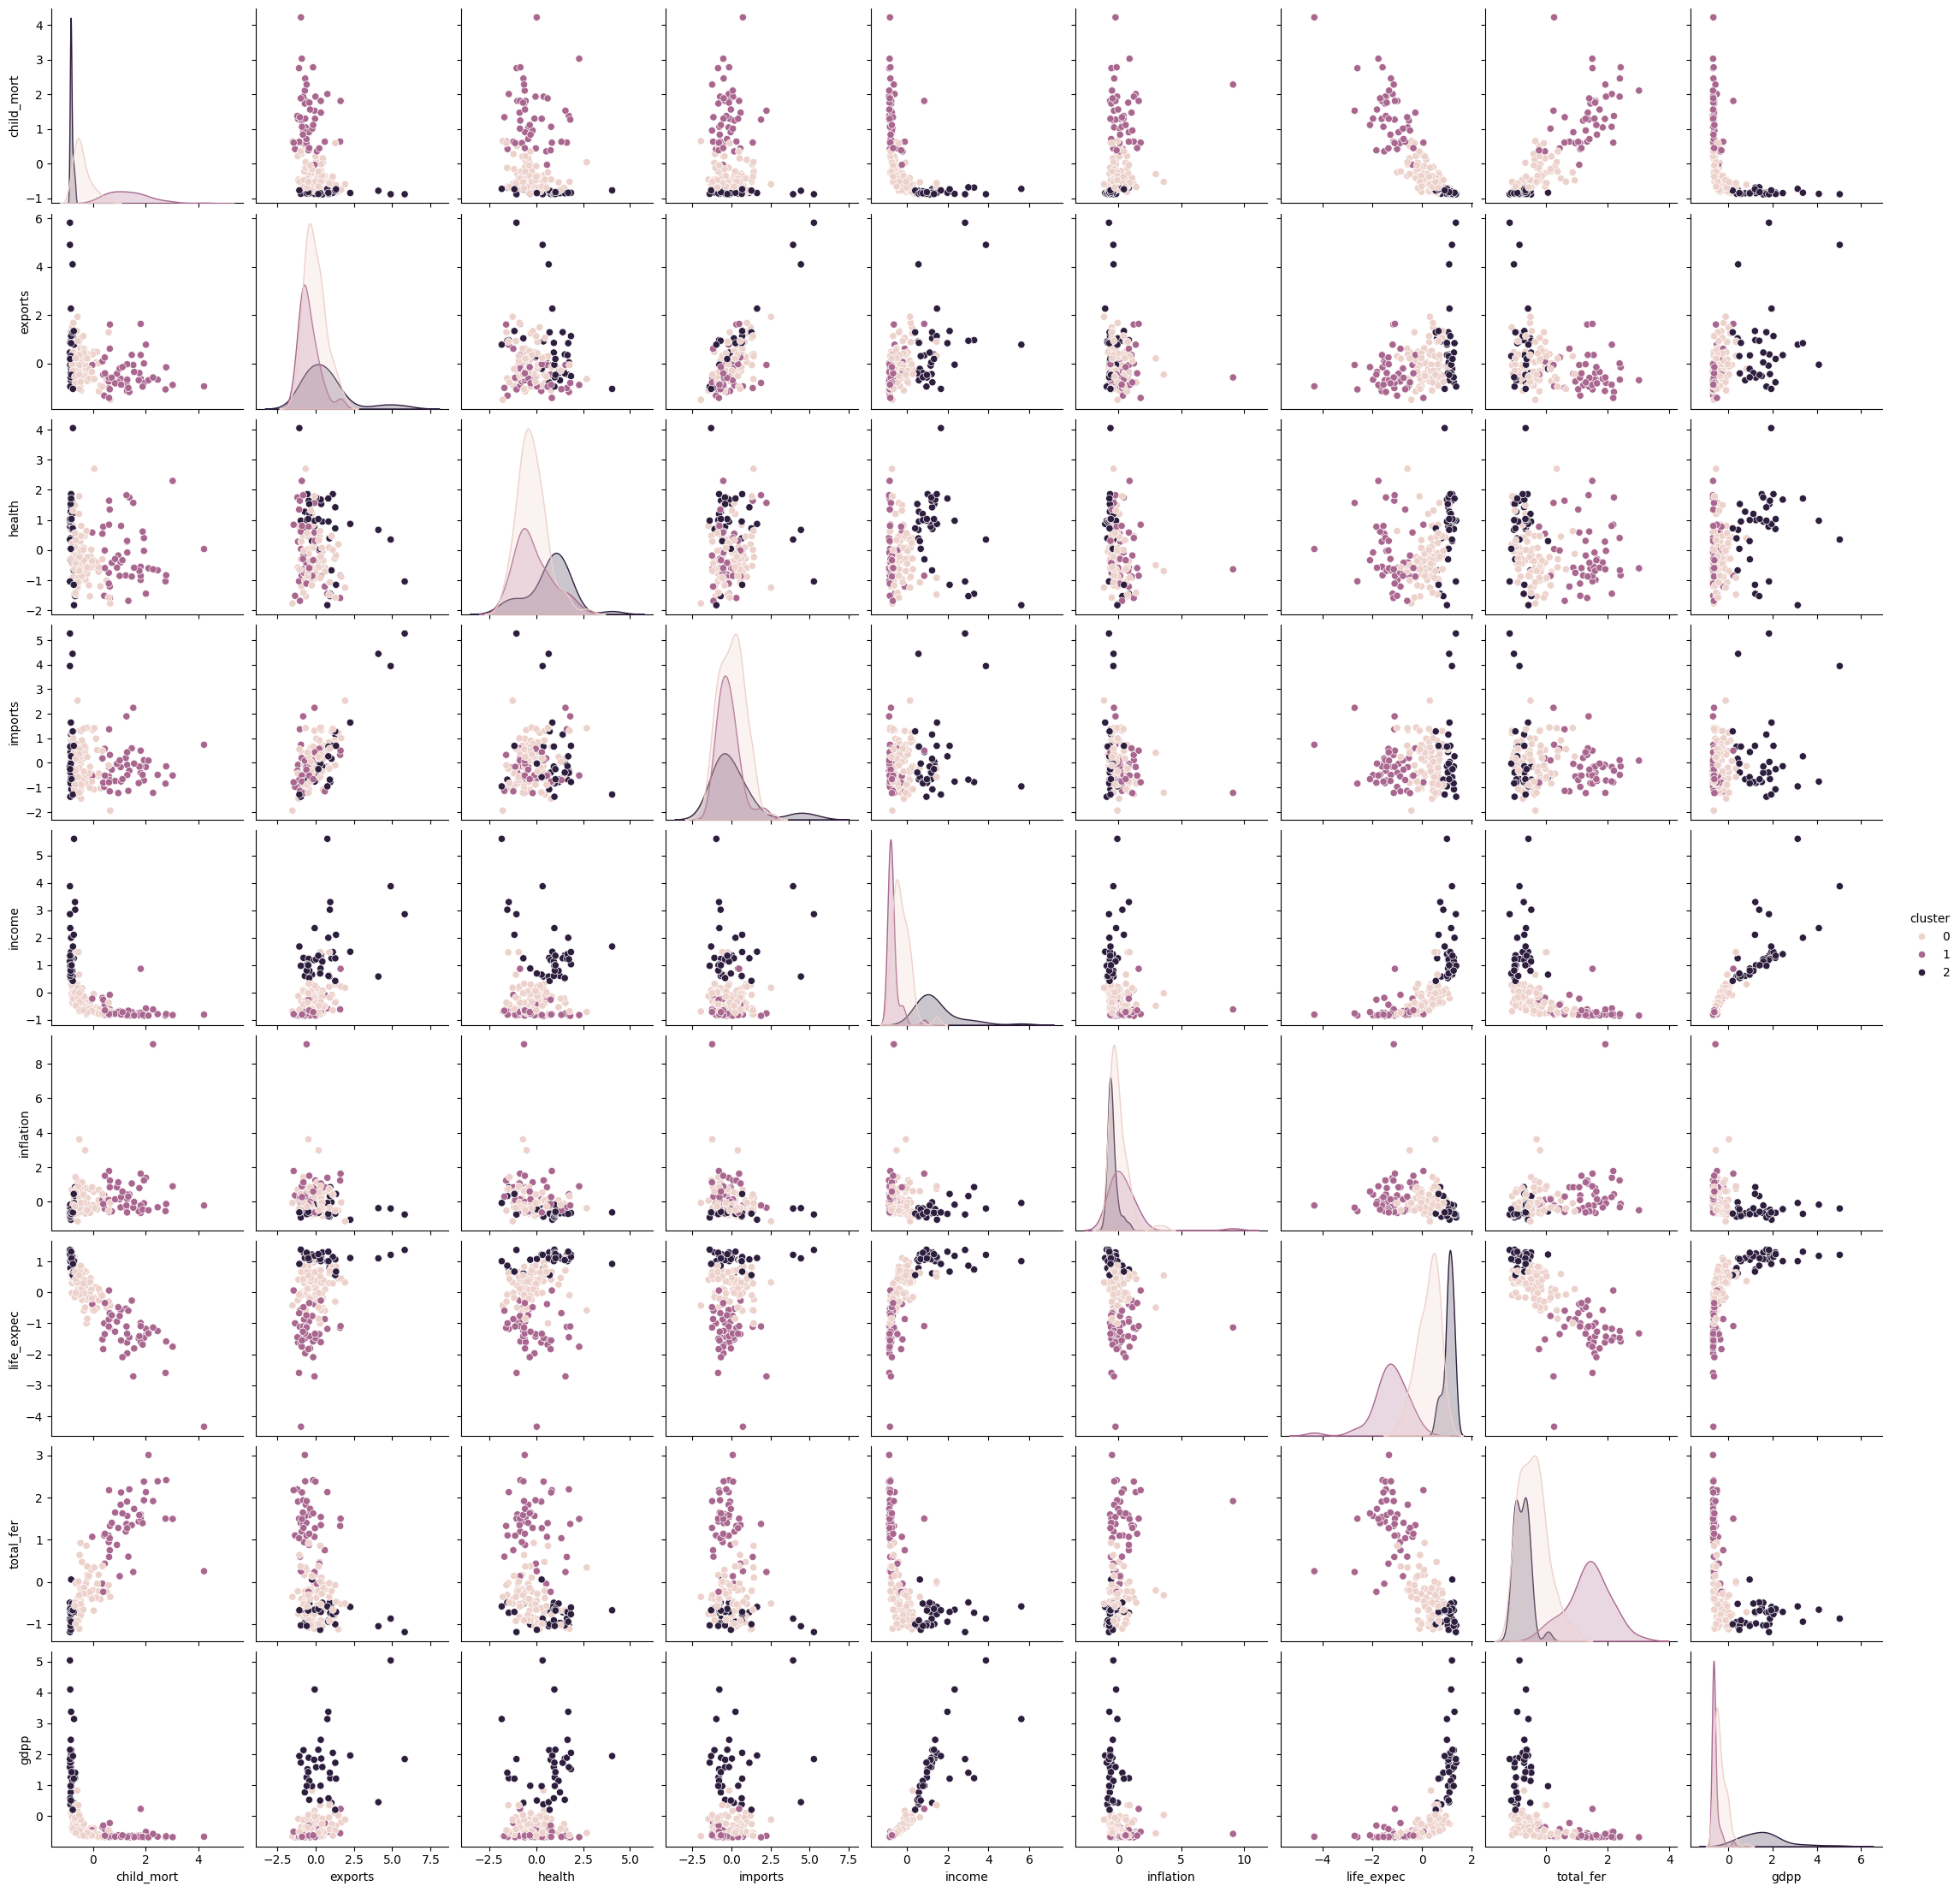

In [14]:
sns.pairplot(results, hue='cluster')

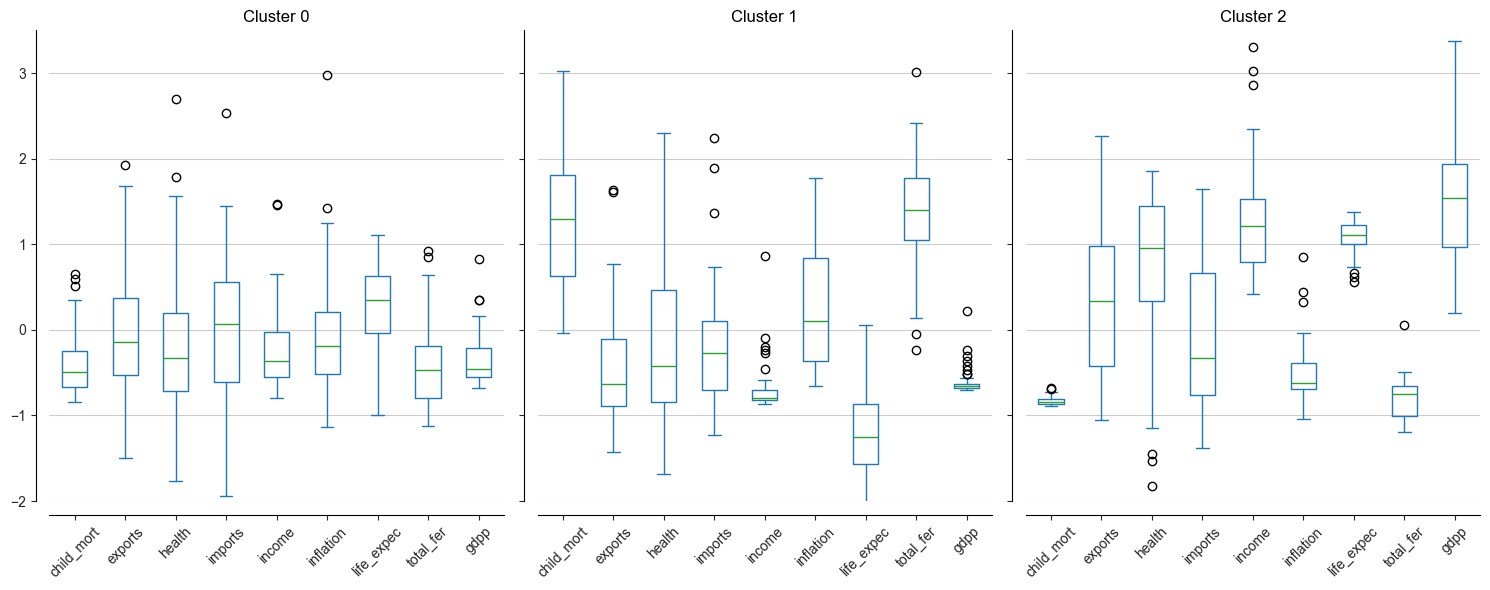

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

sns.set_style('ticks')
for idx in range(0, 3):
    box_plot = country_data_scaled[results.cluster==idx].plot(kind='box', ax=axes[idx])
    axes[idx].set_title(f'Cluster {idx}')
    axes[idx].yaxis.grid(True)
    axes[idx].set_ylim([-2, 3.5])
    sns.despine(offset=10)

# Rotacionar as legendas do eixo x em 45 graus em todos os subplots
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

fig.tight_layout()


Calculando a distância Euclidiana para descobrir qual país representa melhor cada cluster

In [16]:
def get_distance(dist):
    return euclidean(cluster, dist)

for idx in range(3):
    cluster = model.cluster_centers_[idx, :]
    country = country_data_scaled[results.cluster == idx]
    distances = country.apply(get_distance, axis=1)
    dist_min = distances.argmin()
    print(f"O país que mais representa o cluster {idx} é o {distances.index[dist_min]} ({distances[dist_min]:.2f})."
          ,f"{country_data.loc[country_data[results.cluster == idx].index[dist_min], ['child_mort', 'total_fer', 'life_expec', 'gdpp']]}"
          , "\n\n" )
    print()
results.cluster.value_counts().sort_index()


O país que mais representa o cluster 0 é o Jamaica (0.73). child_mort      18.10
total_fer        2.17
life_expec      74.70
gdpp          4680.00
Name: Jamaica, dtype: float64 



O país que mais representa o cluster 1 é o Guinea (0.83). child_mort    109.00
total_fer       5.34
life_expec     58.00
gdpp          648.00
Name: Guinea, dtype: float64 



O país que mais representa o cluster 2 é o Iceland (0.73). child_mort        2.6
total_fer         2.2
life_expec       82.0
gdpp          41900.0
Name: Iceland, dtype: float64 





/var/folders/0d/h4ww2hdn1b912t6nchjlj9940000gn/T/ipykernel_8081/2046712501.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"O país que mais representa o cluster {idx} é o {distances.index[dist_min]} ({distances[dist_min]:.2f})."
/var/folders/0d/h4ww2hdn1b912t6nchjlj9940000gn/T/ipykernel_8081/2046712501.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"O país que mais representa o cluster {idx} é o {distances.index[dist_min]} ({distances[dist_min]:.2f})."
/var/folders/0d/h4ww2hdn1b912t6nchjlj9940000gn/T/ipykernel_8081/2046712501.py:9: FutureWarning: Series.__getitem__ treating keys as positions is

cluster
0    84
1    47
2    36
Name: count, dtype: int64

In [17]:
centers = model.cluster_centers_
centers.shape

(3, 9)

<function matplotlib.pyplot.show(close=None, block=None)>

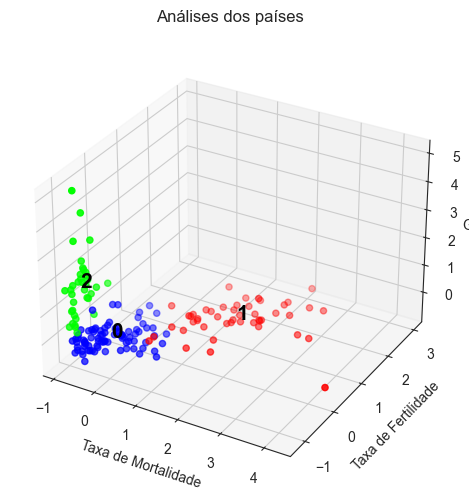

In [18]:

fig = plt.figure(figsize=(5,5))
plt.suptitle("Análises dos países")
ax = plt.axes(projection='3d')
ax.set_xlabel("Taxa de Mortalidade")
ax.set_ylabel("Taxa de Fertilidade")
ax.set_zlabel("GDPP")
ax.scatter3D(results.child_mort,
             results.total_fer,
             results.gdpp,
             c = results.cluster, cmap = "brg")
for j in range(3):
    ax.text(centers[j, num_cols.index('child_mort')],
            centers[j, num_cols.index('total_fer')],
            centers[j, num_cols.index('gdpp')],
            c='black', s=j, fontsize=15, fontweight=700)
plt.tight_layout()
plt.show

<h1>Clusterização Hierárquica<h1>

Text(0, 0.5, 'Child Mortality Rate')

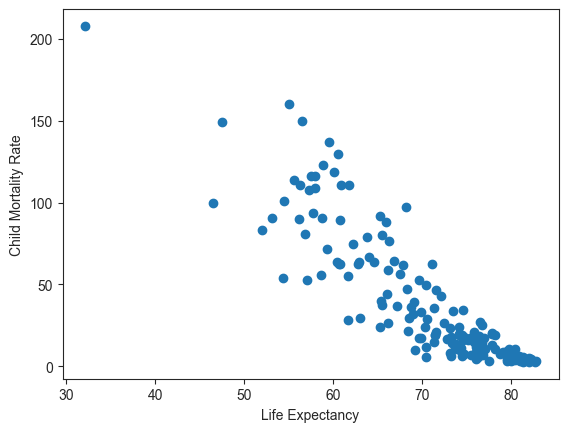

In [19]:
## Escolhendo 2 variáveis. life_expec e child_mort

data = country_data[[ 'life_expec', 'child_mort']]
plt.scatter(data.iloc[:, 0], data.iloc[:, 1])
plt.xlabel("Life Expectancy")
plt.ylabel("Child Mortality Rate")

Text(0, 0.5, 'Distance')

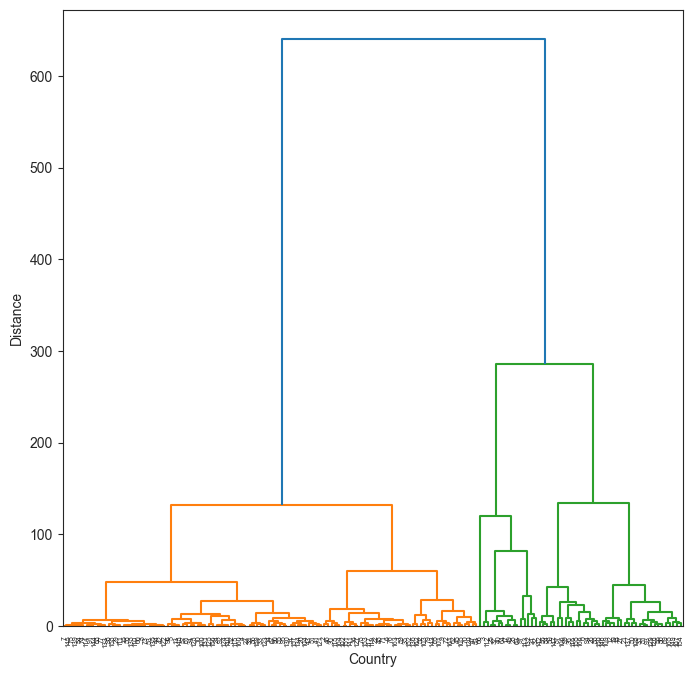

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))

linkage = sch.linkage(data, method="ward")

dend = sch.dendrogram(linkage, get_leaves=True)
plt.xlabel("Country")
plt.ylabel("Distance")

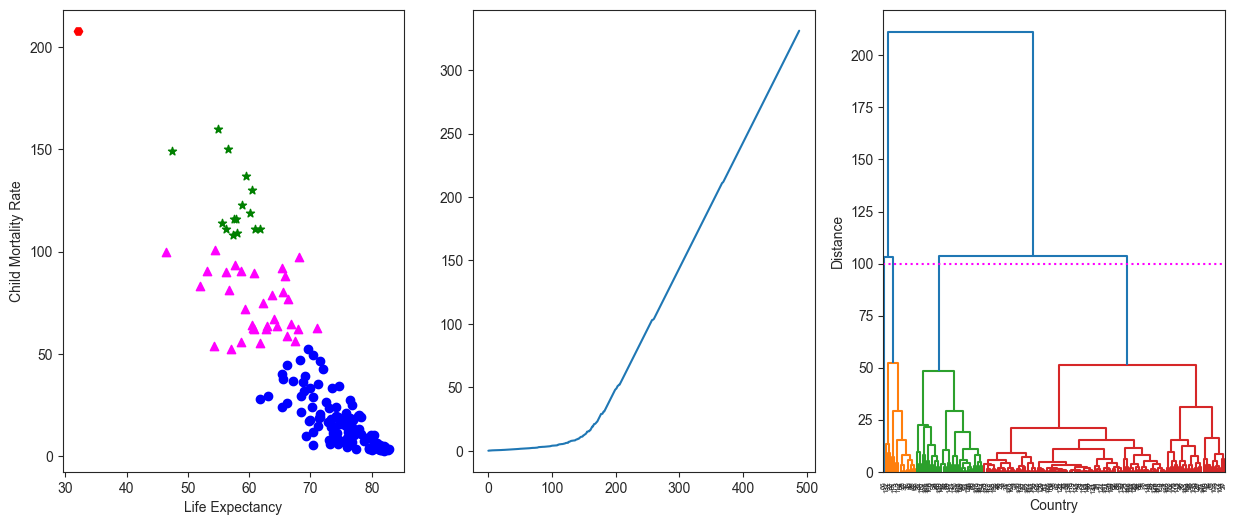

In [21]:
from sklearn.cluster import AgglomerativeClustering

distance_threshold = 100
linkage_method =  'complete'

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

ax = axes[2]
linkage =  sch.linkage(data, method=linkage_method)
dend = sch.dendrogram(linkage, color_threshold=distance_threshold,
                      get_leaves=True)
ax.set_xlabel("Country")
ax.set_ylabel("Distance")
ax.axhline(distance_threshold, c='magenta', ls=":")

axes[1].plot(np.unique(linkage))

ax = axes[0]
model = AgglomerativeClustering(n_clusters=None,
                                linkage=linkage_method,
                                distance_threshold=distance_threshold)
clusters = model.fit(data)

labels = model.labels_

colors = ['g', 'b', 'magenta', 'r', 'c'] * 10
markers = ['*', "o", '^', 'H'] * 10

for cluster in np.unique(labels):
    indices = np.where(labels == cluster)[0]
    ax.scatter(data.iloc[indices, 0], data.iloc[indices, 1], c=colors[cluster], marker=markers[cluster])
    ax.set_xlabel("Life Expectancy")
    ax.set_ylabel("Child Mortality Rate")

In [22]:
output_rows = []
input = data
for index, (leave, cluster) in enumerate(zip(dend['leaves'], dend['leaves_color_list'])):
    output_row = {
        'Country': input.index[leave],
        'Child Mort': input.child_mort[leave],
        'Life Expec' : input.life_expec[leave],
        'Leave': leave,
        'Cluster': cluster
    }
    output_rows.append(output_row)

output_df = pd.DataFrame(output_rows)

cluster_counts = output_df['Cluster'].value_counts()

/var/folders/0d/h4ww2hdn1b912t6nchjlj9940000gn/T/ipykernel_8081/2516249937.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Child Mort': input.child_mort[leave],
/var/folders/0d/h4ww2hdn1b912t6nchjlj9940000gn/T/ipykernel_8081/2516249937.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Life Expec' : input.life_expec[leave],


In [23]:
cluster_counts


Cluster
C3    118
C2     33
C1     15
C0      1
Name: count, dtype: int64

In [24]:
output_df[output_df['Cluster'] == 'C0']


,Country,Child Mort,Life Expec,Leave,Cluster
0,Haiti,208.0,32.1,66,C0


In [25]:
output_df[output_df['Cluster'] == 'C1']


,Country,Child Mort,Life Expec,Leave,Cluster
1,Sierra Leone,160.0,55.0,132,C1
2,Central African Republic,149.0,47.5,31,C1
3,Chad,150.0,56.5,32,C1
4,Mali,137.0,59.5,97,C1
5,Nigeria,130.0,60.5,113,C1
6,Angola,119.0,60.1,3,C1
7,Niger,123.0,58.8,112,C1
8,Guinea-Bissau,114.0,55.6,64,C1
9,Burkina Faso,116.0,57.9,25,C1
10,"Congo, Dem. Rep.",116.0,57.5,37,C1


In [26]:
output_df[output_df['Cluster'] == 'C2']


,Country,Child Mort,Life Expec,Leave,Cluster
16,Mauritania,97.4,68.2,99,C2
17,Comoros,88.2,65.9,36,C2
18,Pakistan,92.1,65.3,116,C2
19,Lesotho,99.7,46.5,87,C2
20,Mozambique,101.0,54.5,106,C2
21,Uganda,81.0,56.8,155,C2
22,Zambia,83.1,52.0,166,C2
23,Afghanistan,90.2,56.2,0,C2
24,Malawi,90.5,53.1,94,C2
25,Burundi,93.6,57.7,26,C2


In [27]:
output_df[output_df['Cluster'] == 'C3']


,Country,Child Mort,Life Expec,Leave,Cluster
49,Jordan,21.1,75.8,78,C3
50,Turkey,19.1,78.2,153,C3
51,Panama,19.7,77.8,117,C3
52,Peru,20.3,77.9,119,C3
53,Colombia,18.6,76.4,35,C3
...,...,...,...,...,...
162,Azerbaijan,39.2,69.1,9,C3
163,Iraq,36.9,67.2,72,C3
164,Uzbekistan,36.3,68.8,161,C3
165,Bhutan,42.7,72.1,18,C3


In [28]:
output_df['Life Expec'][output_df['Cluster'] == 'C1'].min()


47.5

<h1>Diferenças e semelhanças no resultados</h1>

In [29]:
output_df[output_df['Country'] == 'Jamaica']

,Country,Child Mort,Life Expec,Leave,Cluster
59,Jamaica,18.1,74.7,76,C3


In [30]:
output_df[output_df['Country'] == 'Iceland']

,Country,Child Mort,Life Expec,Leave,Cluster
100,Iceland,2.6,82.0,68,C3


Observa-se que no K-Mean, os países que mais se destacavam em seus grupos eram:

Jamaica no cluster 2 e Islândia no cluster 0. Já na análise por clusterização hierárquica, Jamaica e Islândia fazem parte do mesmo grupo.


<p> Ao examinar os resultados da clusterização hierárquica, vemos a separação em 3 clusters e podemos notar um outlier (no gráfico em vermelho), este país é Haiti.
</p>

In [32]:
#Buscando o maior valor de taxa de mortalidade

max_life = data['child_mort'].max()

country = data[data['child_mort'] == max_life][['child_mort']]

print(country)

         child_mort
country            
Haiti         208.0


<h1>Análise com DBSCAN</h1>

In [33]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import DBSCAN
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

Analisando as distâncias entre os pontos é possível determinar o eps

In [46]:
country_scaled = pd.DataFrame(country_data_scaled, columns=num_cols, index=country_data.index)
dbscan = DBSCAN(eps=1, min_samples=5)
country_scaled['cluster'] = dbscan.fit_predict(country_scaled)
country_scaled.cluster.value_counts().sort_index()


cluster
-1    94
 0    52
 1    16
 2     5
Name: count, dtype: int64

In [47]:
country_scaled[['cluster'] + num_cols].groupby(['cluster']).mean().T

cluster,-1,0,1,2
child_mort,0.371767,-0.528092,-0.849210,1.220402
exports,0.076043,0.009593,-0.282301,-0.626019
health,-0.200501,-0.000322,1.242856,-0.204370
imports,0.046933,0.133699,-0.584796,-0.401467
income,-0.024811,-0.201174,1.049299,-0.799109
inflation,0.309006,-0.396095,-0.608284,0.256587
life_expec,-0.338754,0.418177,1.178656,-1.752177
total_fer,0.377455,-0.594823,-0.813594,1.693515
gdpp,-0.082187,-0.263061,1.547211,-0.670117


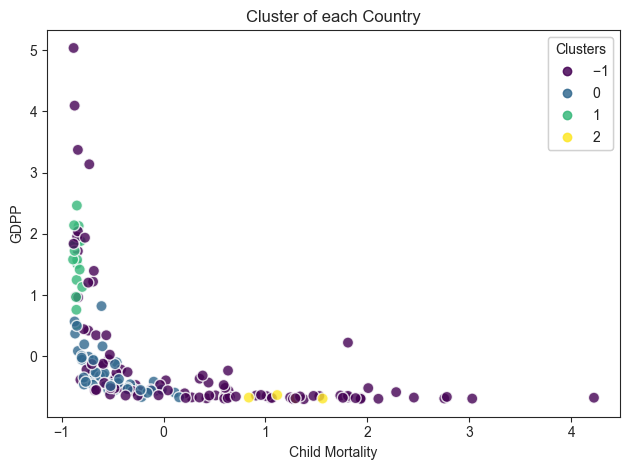

In [49]:

fig, ax = plt.subplots()
ax.set_title("Cluster of each Country")
ax.set_xlabel("Child Mortality")
ax.set_ylabel("GDPP")

sc = ax.scatter(country_scaled.child_mort, country_scaled.gdpp, c=dbscan.labels_, cmap='viridis', edgecolors='white', s=64, alpha=0.8)

legend = ax.legend(*sc.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.tight_layout()
plt.show()

In [51]:
country_scaled[['child_mort', 'gdpp', 'cluster']][country_scaled['cluster'] == 0]

,child_mort,gdpp,cluster
country,,,
Albania,-0.538949,-0.485623,0
Antigua and Barbuda,-0.695634,-0.041817,0
Armenia,-0.501643,-0.533233,0
Bahamas,-0.608587,0.822811,0
Barbados,-0.598639,0.166131,0
Belize,-0.484233,-0.471942,0
Bhutan,0.110176,-0.590145,0
Bosnia and Herzegovina,-0.780194,-0.457167,0
Brazil,-0.459363,-0.096540,0


<h3>Análise DBSCAN</h3>

Após análise do algorítmo DBSCAN, ficou evidenciado que, comparado com K-MEANS e Clusterização Hierárquica, ele é muito mais otimizado para identificar agrupamentos e lidar com dados com maior densidade de variáveis.

A utilização deste algoritmo procura sanar 2 problemas criados pelo K-MEAN (dados aninhados e de muitas dimensões), além de ser um algorítmo muito mais robusto para identificação de outliers.


<h1>Conclusão</h1>
<br>
<p>Após análise dos 3 algoritmos, é possível observar que a sensibilidade a outliers do algoritmo K-Means se deve ao fato da maneira como este algoritmo funciona, uma vez que ele procura encontrar centroides entre os pontos, dados que estão mais afastados podem impactar na geração dos clusters.
O DBSCAN baseia-se no agrupamento utilizando a distância entre pontos (normalmente Euclidiana) junto com a informação da quantidade mínima de pontos, sendo assim, acaba sendo um algoritmo mais robusto para identificação dos clusters e detecção de outliers.</p>